In [1]:
#@title BERT

import torch
from torch import nn
from typing import Tuple
import math

class Attention(nn.Module):
  def __init__(self, d_model, num_heads, dropout):
    super().__init__()

    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = d_model // num_heads
    self.dropout = nn.Dropout(dropout)

    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)
    self.w_o = nn.Linear(d_model, d_model)
  def forward(self, x):
    b, s, _ = x.size() # b = batch_size, # s = sequence length
    # (b, s, num_heads, d_k) → (b, num_heads, s, d_k)
    q = self.w_q(x).view(b, s, self.num_heads, self.d_k).transpose(1,2)
    k = self.w_k(x).view(b, s, self.num_heads, self.d_k).transpose(1,2)
    v = self.w_v(x).view(b, s, self.num_heads, self.d_k).transpose(1,2)

    # scaling
    attn_out = torch.matmul(q, k.transpose(2,3)) / math.sqrt(self.d_k)
    attn_out = torch.softmax(attn_out, dim=-1)
    attn_out = self.dropout(attn_out)
    attn_out = torch.matmul(attn_out, v)
    attn_out = attn_out.transpose(1,2).reshape(b, s, self.d_model)
    attn_out = self.w_o(attn_out)

    return attn_out

class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads, dropout):
    super().__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = d_model // num_heads
    self.dropout = nn.Dropout(dropout)

    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)
    self.w_o = nn.Linear(d_model, d_model)

  def forward(self, q, k, v):
    b, q_len, _ = q.size() # b = batch_size, s = seq_len
    b, kv_len, _ = k.size()
    # (bs, seq, num_heads, d_k) → (bs, num_heads, seq, d_k)
    q = self.w_q(q).view(b, q_len, self.num_heads, self.d_k).transpose(1,2)
    k = self.w_k(k).view(b, kv_len, self.num_heads, self.d_k).transpose(1,2)
    v = self.w_v(v).view(b, kv_len, self.num_heads, self.d_k).transpose(1,2)

    # scaling dividing by math.sqrt(self.d_k)
    attn_out = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
    attn_out = torch.softmax(attn_out, dim=-1)
    attn_out = self.dropout(attn_out)
    attn_out = torch.matmul(attn_out, v)
    attn_out = attn_out.transpose(1,2).reshape(b, q_len, self.d_model)
    attn_out = self.w_o(attn_out)

    return attn_out

class Encoder(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout):
    super().__init__()
    self.attn = MultiHeadAttention(d_model, num_heads, dropout)
    self.dropout1 = nn.Dropout(dropout)
    self.layer_norm1 = nn.LayerNorm(d_model)

    self.ffn = FeedForward(d_model, num_heads, d_ff, dropout)
    self.dropout2 = nn.Dropout(dropout)
    self.layer_norm2 = nn.LayerNorm(d_model)

  def forward(self, x):
    attn_out = self.attn(x, x, x)
    x = x + self.dropout1(attn_out)
    x = self.layer_norm1(x)

    ffn_out = self.ffn(x)
    x = x + self.dropout2(ffn_out)
    x = self.layer_norm2(x)

    return x

class EncoderStack(nn.Module):
  def __init__(self, num_layers, d_model, num_heads, d_ff, dropout):
    super().__init__()
    self.layers = nn.ModuleList([
        Encoder(d_model, num_heads, d_ff, dropout)
        for _ in range(num_layers)
    ])

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

class FeedForward(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout):
    super().__init__()
    self.linear1 = nn.Linear(d_model, d_ff)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(d_ff, d_model)

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu1(x)
    x = self.linear2(x)

    return x

class TokenEmbedding(nn.Module):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    # Token embedding table (vocab_size * d_model)
    self.token_embedding = nn.Embedding(vocab_size, d_model)
    # Optional
    nn.init.normal_(self.token_embedding.weight, mean=0.0, std=0.02)

  def forward(self, token_ids):
    return self.token_embedding(token_ids)

class SegmentEmbedding(nn.Module):
  def __init__(self, num_segments, d_model):
    super().__init__()
    # Segment embedding table (num_segments * d_model)
    self.segment_embedding = nn.Embedding(num_segments, d_model)
    # Optional
    nn.init.normal_(self.segment_embedding.weight, mean=0.0, std=0.02)

  def forward(self, segment_ids):
    return self.segment_embedding(segment_ids)

class PositionEmbedding(nn.Module):
  def __init__(self, max_position_embedding, d_model):
    super().__init__()
    # Position embedding table (max_position_embedding* d_model)
    self.position_embedding = nn.Embedding(max_position_embedding, d_model)
    # Optional
    nn.init.normal_(self.position_embedding.weight, mean=0.0, std=0.02)

  def forward(self, input_ids):
    """
    input_ids: (batch_size, seq_len) posiiton information extraction
    return: (batch_size, seq_len, d_model) position embedding
    """
    batch_size = input_ids.size(0)
    seq_len = input_ids.size(1)
    # Generate position index from 0 to seq_len-1
    position_ids = torch.arange(seq_len, dtype=torch.long, device=input_ids.device)
    # (seq_len, ) -> (batch_size, seq_len)
    position_ids = position_ids.unsqueeze(0).expand(batch_size, -1)

    return self.position_embedding(position_ids)

class Embeddings(nn.Module):
  def __init__(self, vocab_size, d_model, max_position_embedding, num_segments, dropout):
    super().__init__()
    self.token_embedding = TokenEmbedding(vocab_size, d_model)
    self.segment_embedding = SegmentEmbedding(num_segments, d_model)
    self.position_embedding = PositionEmbedding(max_position_embedding, d_model)
    self.layer_norm = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, token_ids, segment_ids, input_ids):
    x = self.token_embedding(token_ids) + self.segment_embedding(segment_ids) + self.position_embedding(input_ids)
    x = self.layer_norm(x)
    x = self.dropout(x)

    return x

class Pooler(nn.Module): # We take the final hidden state of the first token ([CLS]) as the aggregate representation for classification tasks
  def __init__(self, d_model):
    super().__init__()
    self.dense = nn.Linear(d_model, d_model)
    self.activation = nn.Tanh()

  def forward(self, hidden_states):
    # hidden_states: (batch, seq_len, d_model)
    cls_token = hidden_states[:, 0] # (batch, d_model)
    cls_token = self.dense(cls_token)
    cls_token = self.activation(cls_token)

    return cls_token

class Model(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.embeddings = Embeddings(
            config.vocab_size, config.d_model,
            config.max_position_embeddings,
            config.num_segments,
            config.hidden_dropout_prob
        )
    self.encoder = EncoderStack(
            config.num_hidden_layers,
            config.d_model,
            config.num_attention_heads,
            config.intermediate_size, # d_ff
            config.hidden_dropout_prob
        )
    self.pooler = Pooler(config.d_model)

  def forward(self, token_ids, segment_ids):
    x = self.embeddings(token_ids, segment_ids, token_ids)
    x = self.encoder(x)
    pooled = self.pooler(x)

    return x, pooled

class MLM(nn.Module): # Masked LM
  def __init__(self, config, token_embedding_weights):
    super().__init__()
    self.dense = nn.Linear(config.d_model, config.d_model)
    self.activation = nn.GELU()
    self.layer_norm = nn.LayerNorm(config.d_model)
    # decoder: tied weight
    self.predictions = nn.Linear(config.d_model, config.vocab_size, bias=True)
    self.predictions.weight = token_embedding_weights
    self.bias = nn.Parameter(torch.zeros(config.vocab_size))

  def forward(self, hidden_states):
    x = self.dense(hidden_states)
    x = self.activation(x)
    x = self.layer_norm(x)
    x = self.predictions(x) + self.bias

    return x  # (batch, seq_len, vocab_size)

class NSP(nn.Module): # Next Sentence Prediction
  def __init__(self, config):
      super().__init__()
      self.classifier = nn.Linear(config.d_model, 2)

  def forward(self, pooled_output):
      return self.classifier(pooled_output)  # (batch, 2)

class PreTrainedModel(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.bert = Model(config)
    self.mlm = MLM(config, self.bert.embeddings.token_embedding.token_embedding.weight)
    self.nsp = NSP(config)

  def forward(self, token_ids, segment_ids):
    sequence_output, pooled_output = self.bert(token_ids, segment_ids)
    mlm_logits = self.mlm(sequence_output)
    nsp_logits = self.nsp(pooled_output)

    return mlm_logits, nsp_logits

def mask_tokens(
    input_ids: torch.LongTensor,
    mask_token_id: int,
    vocab_size: int,
    mlm_probability: float=0.15,
    special_tokens_mask: torch.BoolTensor=None,
) -> Tuple[torch.LongTensor, torch.LongTensor]:
  """
  input_ids: torch.LongTensor of shape (batch_size, seq_len)
  mask_token_id: id of [MASK] token
  vocab_size: size of vocabulary
  mlm_probability: probability to mask each token
  special_tokens_mask: optional BoolTensor same shape as input_ids,
                        True where token is special ([CLS],[SEP],pad,…)
  returns:
      masked_input_ids: with masked/replaced tokens
      labels: with original token ids at masked positions, -100 elsewhere
  """
  # Make a copy of the input IDs to use as labels for MLM
  labels = input_ids.clone()

  # Select positions to mask
  # Create a matrix filled with the masking probability (e.g., 0.15) for every token
  probability_matrix = torch.full(labels.shape, mlm_probability)
  # If we have a mask for special tokens (e.g., [CLS], [SEP], [PAD]), set their probability to 0
  if special_tokens_mask is not None:
    probability_matrix.masked_fill_(special_tokens_mask, value=0.0)
  # Sample a mask decision for each token (True = will be masked)
  masked_indices = torch.bernoulli(probability_matrix).bool()

  # For tokens that are not selected for masking, set their label to -100 so loss ignores them
  labels[~masked_indices] = -100

  # Replace the selected (masked) tokens

  # 1) 80%, replace masked tokens with the [MASK] token
  # Sample decisions for replacement (True = replace with [MASK])
  indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
  input_ids[indices_replaced] = mask_token_id

  # 2) 10%, replace masked tokens with a random token
  # Sample decisions for random replacement (half of the remaining masked positions)
  indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
  # Draw random token IDs from the full vocabulary
  random_tokens = torch.randint(vocab_size, labels.shape, dtype=torch.long, device=input_ids.device)
  input_ids[indices_random] = random_tokens[indices_random]

  # 3) 10%, unchanged tokens

  # Return the modified input IDs (with masks/random tokens) and the MLM labels
  return input_ids, labels


In [2]:
class BERTConfig:
    def __init__(self):
        self.vocab_size = 30522              # BERT-base vocab size
        self.d_model = 768                   # hidden size
        self.num_attention_heads = 12       # num heads
        self.num_hidden_layers = 12          # encoder layers
        self.max_position_embeddings = 512  # max position embeddings
        self.num_segments = 2                # token type segments (A,B)
        self.hidden_dropout_prob = 0.1       # dropout rate
        self.intermediate_size = 3072         # feed forward hidden dim
        self.learning_rate = 5e-5            # learning rate
        self.weight_decay = 0.01             # weight decay (the paper uses Adam)
        self.eps = 1e-6                      # adam epsilon
        self.batch_size = 32                 # batch size
        self.max_epochs = 47                  # epoch (the paper uses over 40 epoch)
        self.warmup_steps = 10000            # warmup steps (the paper has 10k steps)

In [3]:
#@title Pretraining Dataset: WikiText-2

from datasets import load_dataset
from torch.utils.data import Dataset

class WikiTextDataset(Dataset):
    def __init__(self, tokenizer, seq_len=128, mlm_prob=0.15):
        dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.examples = []

        for doc in dataset["text"]:
            if len(doc) < 50:
                continue
            tok = tokenizer(doc, truncation=True, max_length=seq_len-2, return_attention_mask=False)["input_ids"]
            tok = [tokenizer.cls_token_id] + tok + [tokenizer.sep_token_id]
            if len(tok) < seq_len:
                tok += [tokenizer.pad_token_id] * (seq_len - len(tok))
            self.examples.append(tok)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.examples[idx], dtype=torch.long)
        segment_ids = torch.zeros_like(input_ids, dtype=torch.long)
        special_mask = (input_ids == self.tokenizer.cls_token_id) | (input_ids == self.tokenizer.sep_token_id) | (input_ids == self.tokenizer.pad_token_id)
        masked_input_ids, mlm_labels = mask_tokens(input_ids.clone(), mask_token_id=self.tokenizer.mask_token_id, vocab_size=self.tokenizer.vocab_size, special_tokens_mask=special_mask)
        is_next_label = torch.randint(0, 2, (1,), dtype=torch.long).item()
        return masked_input_ids, segment_ids, mlm_labels, is_next_label


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Epoch 1: 100%|██████████| 512/512 [01:45<00:00,  4.85it/s]


[Epoch 1] MLM loss 9.4593, NSP loss 0.6975, MLM acc 0.0481, NSP acc 0.5017


Epoch 2: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 2] MLM loss 8.3127, NSP loss 0.6959, MLM acc 0.0610, NSP acc 0.4992


Epoch 3: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 3] MLM loss 7.5469, NSP loss 0.6973, MLM acc 0.0712, NSP acc 0.4988


Epoch 4: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 4] MLM loss 7.1637, NSP loss 0.6984, MLM acc 0.0896, NSP acc 0.5051


Epoch 5: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 5] MLM loss 7.0077, NSP loss 0.6983, MLM acc 0.0966, NSP acc 0.4999


Epoch 6: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 6] MLM loss 6.9188, NSP loss 0.6977, MLM acc 0.1034, NSP acc 0.4957


Epoch 7: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 7] MLM loss 6.8328, NSP loss 0.6968, MLM acc 0.1123, NSP acc 0.5069


Epoch 8: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 8] MLM loss 6.7810, NSP loss 0.6979, MLM acc 0.1193, NSP acc 0.4985


Epoch 9: 100%|██████████| 512/512 [01:44<00:00,  4.90it/s]


[Epoch 9] MLM loss 6.7132, NSP loss 0.6968, MLM acc 0.1274, NSP acc 0.4998


Epoch 10: 100%|██████████| 512/512 [01:44<00:00,  4.90it/s]


[Epoch 10] MLM loss 6.6711, NSP loss 0.6972, MLM acc 0.1333, NSP acc 0.5053


Epoch 11: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 11] MLM loss 6.6115, NSP loss 0.6963, MLM acc 0.1374, NSP acc 0.5017


Epoch 12: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 12] MLM loss 6.5861, NSP loss 0.6970, MLM acc 0.1386, NSP acc 0.4981


Epoch 13: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 13] MLM loss 6.5283, NSP loss 0.6955, MLM acc 0.1429, NSP acc 0.5020


Epoch 14: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 14] MLM loss 6.4769, NSP loss 0.6949, MLM acc 0.1463, NSP acc 0.5084


Epoch 15: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 15] MLM loss 6.4372, NSP loss 0.6959, MLM acc 0.1469, NSP acc 0.5021


Epoch 16: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 16] MLM loss 6.4005, NSP loss 0.6964, MLM acc 0.1502, NSP acc 0.5022


Epoch 17: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 17] MLM loss 6.3194, NSP loss 0.6951, MLM acc 0.1571, NSP acc 0.5057


Epoch 18: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 18] MLM loss 6.2780, NSP loss 0.6958, MLM acc 0.1631, NSP acc 0.4985


Epoch 19: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 19] MLM loss 6.2165, NSP loss 0.6950, MLM acc 0.1712, NSP acc 0.5026


Epoch 20: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 20] MLM loss 6.0786, NSP loss 0.6960, MLM acc 0.1918, NSP acc 0.5004


Epoch 21: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 21] MLM loss 5.9171, NSP loss 0.6953, MLM acc 0.2057, NSP acc 0.4955


Epoch 22: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 22] MLM loss 5.7218, NSP loss 0.6944, MLM acc 0.2228, NSP acc 0.5069


Epoch 23: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 23] MLM loss 5.5386, NSP loss 0.6943, MLM acc 0.2391, NSP acc 0.5019


Epoch 24: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 24] MLM loss 5.3752, NSP loss 0.6951, MLM acc 0.2540, NSP acc 0.4927


Epoch 25: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 25] MLM loss 5.2299, NSP loss 0.6945, MLM acc 0.2650, NSP acc 0.5030


Epoch 26: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 26] MLM loss 5.1025, NSP loss 0.6948, MLM acc 0.2758, NSP acc 0.4965


Epoch 27: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 27] MLM loss 4.9950, NSP loss 0.6944, MLM acc 0.2842, NSP acc 0.5018


Epoch 28: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 28] MLM loss 4.9008, NSP loss 0.6945, MLM acc 0.2925, NSP acc 0.4973


Epoch 29: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 29] MLM loss 4.8326, NSP loss 0.6941, MLM acc 0.2983, NSP acc 0.5028


Epoch 30: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 30] MLM loss 4.7468, NSP loss 0.6940, MLM acc 0.3051, NSP acc 0.5032


Epoch 31: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 31] MLM loss 4.6873, NSP loss 0.6940, MLM acc 0.3103, NSP acc 0.4969


Epoch 32: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 32] MLM loss 4.6504, NSP loss 0.6940, MLM acc 0.3129, NSP acc 0.5034


Epoch 33: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 33] MLM loss 4.5742, NSP loss 0.6940, MLM acc 0.3199, NSP acc 0.4994


Epoch 34: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 34] MLM loss 4.5246, NSP loss 0.6937, MLM acc 0.3242, NSP acc 0.5028


Epoch 35: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 35] MLM loss 4.4768, NSP loss 0.6940, MLM acc 0.3279, NSP acc 0.4997


Epoch 36: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 36] MLM loss 4.4321, NSP loss 0.6935, MLM acc 0.3330, NSP acc 0.5021


Epoch 37: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 37] MLM loss 4.4034, NSP loss 0.6937, MLM acc 0.3348, NSP acc 0.5056


Epoch 38: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 38] MLM loss 4.3660, NSP loss 0.6936, MLM acc 0.3390, NSP acc 0.4960


Epoch 39: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 39] MLM loss 4.3402, NSP loss 0.6934, MLM acc 0.3407, NSP acc 0.5028


Epoch 40: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 40] MLM loss 4.3036, NSP loss 0.6936, MLM acc 0.3438, NSP acc 0.5004


Epoch 41: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 41] MLM loss 4.2665, NSP loss 0.6935, MLM acc 0.3477, NSP acc 0.4994


Epoch 42: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 42] MLM loss 4.2489, NSP loss 0.6934, MLM acc 0.3496, NSP acc 0.4995


Epoch 43: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 43] MLM loss 4.2248, NSP loss 0.6936, MLM acc 0.3506, NSP acc 0.4947


Epoch 44: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 44] MLM loss 4.2117, NSP loss 0.6934, MLM acc 0.3514, NSP acc 0.4986


Epoch 45: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 45] MLM loss 4.1829, NSP loss 0.6934, MLM acc 0.3551, NSP acc 0.4973


Epoch 46: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 46] MLM loss 4.1783, NSP loss 0.6933, MLM acc 0.3557, NSP acc 0.4981


Epoch 47: 100%|██████████| 512/512 [01:44<00:00,  4.91it/s]


[Epoch 47] MLM loss 4.1559, NSP loss 0.6932, MLM acc 0.3572, NSP acc 0.5055


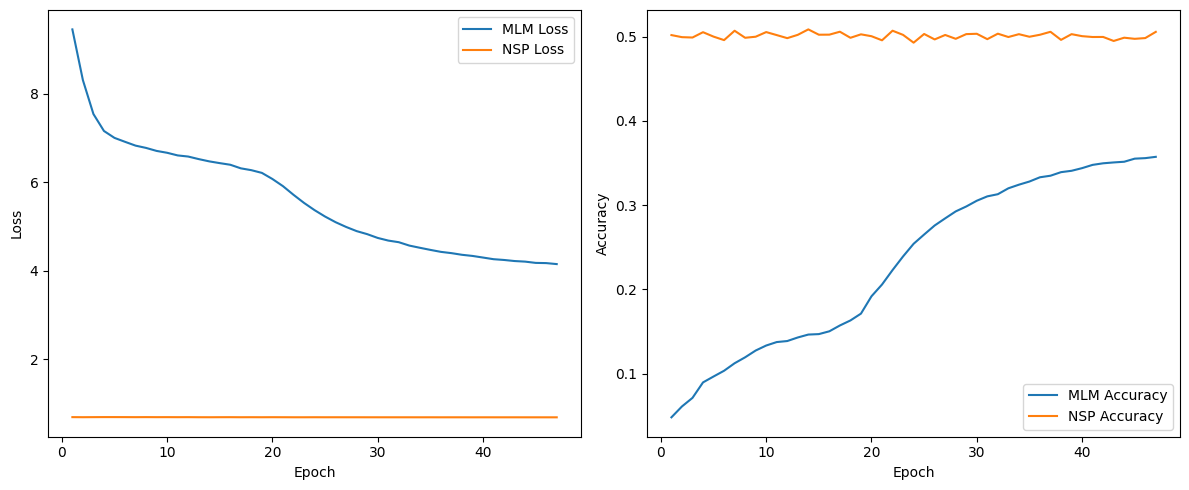

MLM Loss: 4.1559
NSP Loss: 0.6932
MLM Accuracy: 0.3572
NSP Accuracy: 0.5055
Perplexity (MLM): 63.8085


In [4]:
#@title Training and Evaluation

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

config = BERTConfig()

config.vocab_size = tokenizer.vocab_size

def train_and_eval(config, tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PreTrainedModel(config).to(device)
    criterion_mlm = nn.CrossEntropyLoss(ignore_index=-100)
    criterion_nsp = nn.CrossEntropyLoss()

    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, eps=config.eps, weight_decay=config.weight_decay)
    dataset = WikiTextDataset(tokenizer, seq_len=128, mlm_prob=0.15)
    dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)
    total_steps = len(dataloader) * config.max_epochs
    from transformers import get_linear_schedule_with_warmup
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=config.warmup_steps, num_training_steps=total_steps)

    mlm_losses, nsp_losses, tot_losses = [], [], []
    mlm_accs, nsp_accs = [], []

    for epoch in range(config.max_epochs):
        model.train()
        epoch_mlm_loss = epoch_nsp_loss = 0.0
        epoch_mlm_acc = epoch_nsp_acc = 0.0

        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            input_ids, segment_ids, mlm_labels, is_next = [x.to(device) for x in batch]
            optimizer.zero_grad()
            mlm_logits, nsp_logits = model(input_ids, segment_ids)
            mlm_loss = criterion_mlm(mlm_logits.view(-1, config.vocab_size), mlm_labels.view(-1))
            nsp_loss = criterion_nsp(nsp_logits, is_next)
            loss = mlm_loss + nsp_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step(); scheduler.step()

            epoch_mlm_loss += mlm_loss.item()
            epoch_nsp_loss += nsp_loss.item()
            # Accuracy
            mask = mlm_labels != -100
            mlm_acc = (mlm_logits.argmax(dim=-1)[mask] == mlm_labels[mask]).float().mean().item()
            nsp_acc = (nsp_logits.argmax(dim=-1) == is_next).float().mean().item()
            epoch_mlm_acc += mlm_acc
            epoch_nsp_acc += nsp_acc

        mlm_losses.append(epoch_mlm_loss / len(dataloader))
        nsp_losses.append(epoch_nsp_loss / len(dataloader))
        tot_losses.append((epoch_mlm_loss + epoch_nsp_loss) / len(dataloader))
        mlm_accs.append(epoch_mlm_acc / len(dataloader))
        nsp_accs.append(epoch_nsp_acc / len(dataloader))

        print(f"[Epoch {epoch+1}] MLM loss {mlm_losses[-1]:.4f}, NSP loss {nsp_losses[-1]:.4f}, MLM acc {mlm_accs[-1]:.4f}, NSP acc {nsp_accs[-1]:.4f}")

    # Visualization
    epochs = range(1, config.max_epochs+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, mlm_losses, label='MLM Loss')
    plt.plot(epochs, nsp_losses, label='NSP Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, mlm_accs, label='MLM Accuracy')
    plt.plot(epochs, nsp_accs, label='NSP Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "mlm_losses": mlm_losses,
        "nsp_losses": nsp_losses,
        "mlm_accs": mlm_accs,
        "nsp_accs": nsp_accs,
        "tot_losses": tot_losses,
        "model": model
    }

results = train_and_eval(config, tokenizer)

# Calculate Perplexity from MLM Loss
final_mlm_loss = results["mlm_losses"][-1]
perplexity = math.exp(final_mlm_loss)

print(f"MLM Loss: {results['mlm_losses'][-1]:.4f}")
print(f"NSP Loss: {results['nsp_losses'][-1]:.4f}")
print(f"MLM Accuracy: {results['mlm_accs'][-1]:.4f}")
print(f"NSP Accuracy: {results['nsp_accs'][-1]:.4f}")
print(f"Perplexity (MLM): {perplexity:.4f}")

In [5]:
#@title MLM Prediction
def show_mlm_predictions(model, tokenizer, sentences):
    model.eval()
    device = next(model.parameters()).device

    for sentence in sentences:
        encoding = tokenizer(sentence, return_tensors='pt')
        input_ids = encoding['input_ids'].to(device)
        token_type_ids = encoding['token_type_ids'].to(device)

        with torch.no_grad():
            mlm_logits, _ = model(input_ids, token_type_ids)

        mask_token_index = (input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
        predicted_token_id = mlm_logits[0, mask_token_index].argmax(dim=-1)
        predicted_token = tokenizer.decode(predicted_token_id)
        original_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

        reconstructed = original_tokens.copy()
        reconstructed[mask_token_index.item()] = predicted_token

        print("Original Sentence: ", sentence)
        print("Predicted Token: ", predicted_token)
        print("Full Reconstructed Sentence: ", tokenizer.convert_tokens_to_string(reconstructed))
        print("-" * 50)

# Test sentences list
sentences = [
    "The capital of France is [MASK].",
    "The president of the United States is [MASK].",
    "Water freezes at [MASK] degrees Celsius.",
    "Python is a popular [MASK] programming language.",
    "The sky is [MASK]."
]

model = results["model"]
show_mlm_predictions(model, tokenizer, sentences)


Original Sentence:  The capital of France is [MASK].
Predicted Token:  born
Full Reconstructed Sentence:  [CLS] the capital of france is born . [SEP]
--------------------------------------------------
Original Sentence:  The president of the United States is [MASK].
Predicted Token:  president
Full Reconstructed Sentence:  [CLS] the president of the united states is president . [SEP]
--------------------------------------------------
Original Sentence:  Water freezes at [MASK] degrees Celsius.
Predicted Token:  two
Full Reconstructed Sentence:  [CLS] water freezes at two degrees celsius . [SEP]
--------------------------------------------------
Original Sentence:  Python is a popular [MASK] programming language.
Predicted Token:  and
Full Reconstructed Sentence:  [CLS] python is a popular and programming language . [SEP]
--------------------------------------------------
Original Sentence:  The sky is [MASK].
Predicted Token:  a
Full Reconstructed Sentence:  [CLS] the sky is a . [SEP]


In [6]:
#@title NSP Prediction
def show_nsp_predictions(model, tokenizer, sentence_pairs):
    model.eval()
    device = next(model.parameters()).device
    label_map = {0: "IsNext", 1: "NotNext"}

    for sentence_a, sentence_b in sentence_pairs:
        encoding = tokenizer(sentence_a, sentence_b, return_tensors='pt')
        input_ids = encoding['input_ids'].to(device)
        token_type_ids = encoding['token_type_ids'].to(device)

        with torch.no_grad():
            _, nsp_logits = model(input_ids, token_type_ids)

        predicted_label = torch.argmax(nsp_logits, dim=-1).item()

        print(f"Sentence A: {sentence_a}")
        print(f"Sentence B: {sentence_b}")
        print("Predicted NSP Label:", label_map[predicted_label])
        print("-" * 50)

# Test sentences list
sentence_pairs = [
    ("The sky is blue.", "The sun is bright."),
    ("I love pizza.", "It is raining outside."),
    ("She went to the store.", "She bought some milk."),
    ("The cat is sleeping.", "Dogs bark loudly."),
    ("This is a test.", "This is not related.")
]

show_nsp_predictions(model, tokenizer, sentence_pairs)


Sentence A: The sky is blue.
Sentence B: The sun is bright.
Predicted NSP Label: NotNext
--------------------------------------------------
Sentence A: I love pizza.
Sentence B: It is raining outside.
Predicted NSP Label: NotNext
--------------------------------------------------
Sentence A: She went to the store.
Sentence B: She bought some milk.
Predicted NSP Label: NotNext
--------------------------------------------------
Sentence A: The cat is sleeping.
Sentence B: Dogs bark loudly.
Predicted NSP Label: NotNext
--------------------------------------------------
Sentence A: This is a test.
Sentence B: This is not related.
Predicted NSP Label: NotNext
--------------------------------------------------


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

FT Epoch 1: 100%|██████████| 3750/3750 [10:22<00:00,  6.02it/s]


[Epoch 1] Loss: 0.3466, Acc: 0.8733


FT Epoch 2: 100%|██████████| 3750/3750 [10:22<00:00,  6.02it/s]


[Epoch 2] Loss: 0.1833, Acc: 0.9369


FT Epoch 3: 100%|██████████| 3750/3750 [10:23<00:00,  6.02it/s]


[Epoch 3] Loss: 0.1329, Acc: 0.9543


FT Epoch 4: 100%|██████████| 3750/3750 [10:23<00:00,  6.02it/s]


[Epoch 4] Loss: 0.0948, Acc: 0.9672


FT Epoch 5: 100%|██████████| 3750/3750 [10:22<00:00,  6.02it/s]


[Epoch 5] Loss: 0.0663, Acc: 0.9770


FT Epoch 6: 100%|██████████| 3750/3750 [10:23<00:00,  6.02it/s]


[Epoch 6] Loss: 0.0448, Acc: 0.9840


FT Epoch 7: 100%|██████████| 3750/3750 [10:23<00:00,  6.02it/s]


[Epoch 7] Loss: 0.0290, Acc: 0.9896


FT Epoch 8: 100%|██████████| 3750/3750 [10:22<00:00,  6.02it/s]


[Epoch 8] Loss: 0.0185, Acc: 0.9937
Test Accuracy: 0.9317


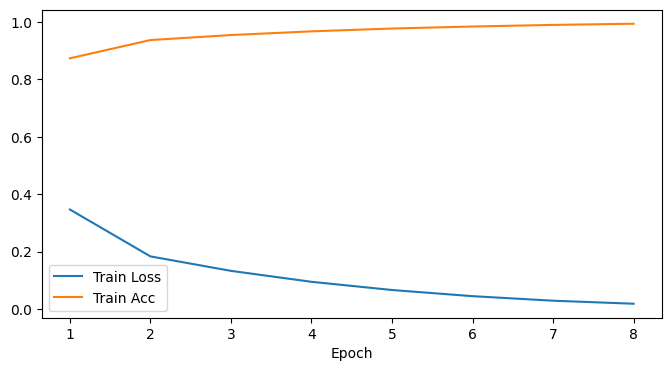

In [7]:
#@title Fine-Tuning

from transformers import get_linear_schedule_with_warmup

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
config.vocab_size = tokenizer.vocab_size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# AG News dataset
dataset = load_dataset("ag_news")

def preprocess(batch):
    enc = tokenizer(batch["text"],
                    truncation=True,
                    padding="max_length",
                    max_length=128)
    return {
        "input_ids":enc["input_ids"],
        "token_type_ids":enc["token_type_ids"],
        "labels":batch["label"]
    }

train_ds = dataset["train"].map(preprocess, batched=True)
test_ds = dataset["test"].map(preprocess,  batched=True)

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, ds):
      self.ds = ds
    def __len__(self):
      return len(self.ds)
    def __getitem__(self, i):
        item = self.ds[i]
        return (
            torch.tensor(item["input_ids"]),
            torch.tensor(item["token_type_ids"]),
            torch.tensor(item["labels"])
        )

train_dl = DataLoader(NewsDataset(train_ds), batch_size=32, shuffle=True)
test_dl = DataLoader(NewsDataset(test_ds),  batch_size=32)

# Fine-tuning model
num_labels = 4
class BertForSequenceClassification(nn.Module):
    def __init__(self, config, pretrained_bert):
        super().__init__()
        self.bert       = pretrained_bert
        self.classifier = nn.Linear(config.d_model, num_labels)

    def forward(self, input_ids, segment_ids):
        _, pooled = self.bert(input_ids, segment_ids)
        return self.classifier(pooled)

pretrained_bert = results["model"].bert.to(device)

# Fine-tuning setting
model = BertForSequenceClassification(config, pretrained_bert).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
total_steps = len(train_dl) * 8  # 8 epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
               num_warmup_steps=500,
               num_training_steps=total_steps)

# Fine-tuning
train_losses, train_accs = [], []
for epoch in range(8):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    for input_ids, token_type_ids, labels in tqdm(train_dl, desc=f"FT Epoch {epoch+1}"):
        input_ids, token_type_ids, labels = (
            input_ids.to(device),
            token_type_ids.to(device),
            labels.to(device)
        )
        optimizer.zero_grad()
        logits = model(input_ids, token_type_ids)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        preds = logits.argmax(dim=-1)
        epoch_acc += (preds == labels).float().mean().item()

    train_losses.append(epoch_loss / len(train_dl))
    train_accs.append(epoch_acc / len(train_dl))
    print(f"[Epoch {epoch+1}] Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f}")

# Evaluation
model.eval()
test_acc = 0.0
with torch.no_grad():
    for input_ids, token_type_ids, labels in test_dl:
        input_ids, token_type_ids, labels = (
            input_ids.to(device),
            token_type_ids.to(device),
            labels.to(device)
        )
        logits = model(input_ids, token_type_ids)
        preds = logits.argmax(dim=-1)
        test_acc += (preds == labels).float().mean().item()

print(f"Test Accuracy: {test_acc/len(test_dl):.4f}")

# Visualization
plt.figure(figsize=(8,4))
plt.plot(range(1,9), train_losses, label="Train Loss")
plt.plot(range(1,9), train_accs,   label="Train Acc")
plt.xlabel("Epoch")
plt.legend()
plt.show()
